In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from skimage.feature import local_binary_pattern
import cv2
import pandas as pd
from tqdm import tqdm

In [27]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

KeyboardInterrupt: 

# Loading data

Directory structure for: data\Crop Diseases Dataset\Crop Diseases\Crop___Disease
├── Corn/
  ├── Corn___Common_Rust/
    ├── image (1).JPG
    ├── image (10).JPG
    ├── image (100).JPG
    ├── image (1000).JPG
    ├── image (1001).JPG
    ├── image (1002).JPG
    ├── image (1003).JPG
    ├── image (1004).JPG
    ├── image (1005).JPG
    ├── image (1006).JPG
    ├── image (1007).JPG
    ├── image (1008).JPG
    ├── image (1009).JPG
    ├── image (101).JPG
    ├── image (1010).JPG
    ├── image (1011).JPG
    ├── image (1012).JPG
    ├── image (1013).JPG
    ├── image (1014).JPG
    ├── image (1015).JPG
    ├── image (1016).JPG
    ├── image (1017).JPG
    ├── image (1018).JPG
    ├── image (1019).JPG
    ├── image (102).JPG
    ├── image (1020).JPG
    ├── image (1021).JPG
    ├── image (1022).JPG
    ├── image (1023).JPG
    ├── image (1024).JPG
    ├── image (1025).JPG
    ├── image (1026).JPG
    ├── image (1027).JPG
    ├── image (1028).JPG
    ├── image (1029).JPG
    ├── image (1

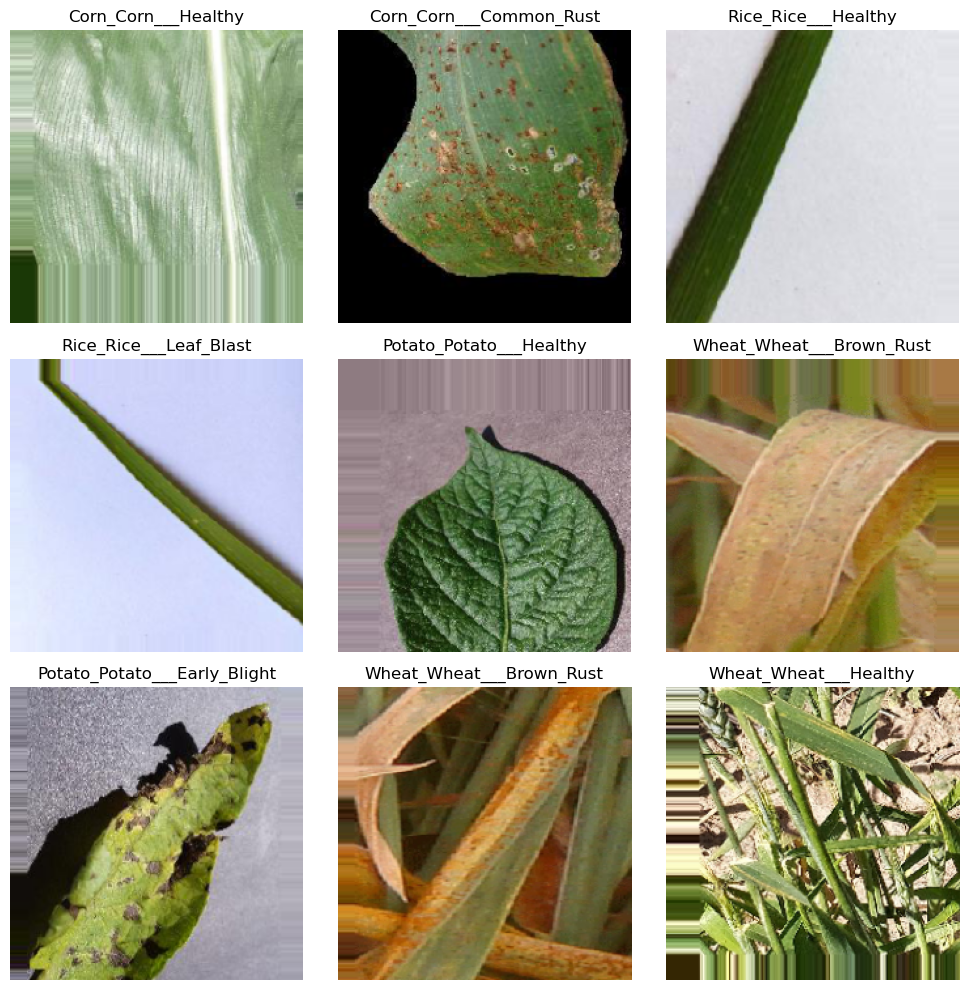

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
import tempfile

# Print the current directory structure to understand what we're working with
def print_directory_tree(root_dir, level=0):
    if level == 0:
        print(f"Directory structure for: {root_dir}")

    items = os.listdir(root_dir)
    indent = '  ' * level

    for item in items:
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path):
            print(f"{indent}├── {item}/")
            if level < 3:  # Limit depth to avoid excessive output
                print_directory_tree(item_path, level + 1)
        elif level <= 3:  # Only show files at top levels
            print(f"{indent}├── {item}")

# Set the base directory where Crop__Disease folder is located
base_dir = "data\\Crop Diseases Dataset\\Crop Diseases\\Crop___Disease"
print_directory_tree(base_dir)

# Function to prepare datasets from crop-specific folders
def prepare_datasets(base_dir, train_split=0.7, val_split=0.15):
    # Lists to hold all file paths and their labels
    all_images = []
    all_labels = []
    class_map = {}

    # Process each crop folder
    for crop_folder in os.listdir(base_dir):
        crop_path = os.path.join(base_dir, crop_folder)

        # Skip if not a directory
        if not os.path.isdir(crop_path):
            continue

        # Process each disease folder under this crop
        for disease_folder in os.listdir(crop_path):
            disease_path = os.path.join(crop_path, disease_folder)

            # Skip if not a directory
            if not os.path.isdir(disease_path):
                continue

            # The class name is the disease name
            class_name = f"{crop_folder}_{disease_folder}"

            # Assign a numeric label if it's the first time seeing this class
            if class_name not in class_map:
                class_map[class_name] = len(class_map)

            # Find all image files in this disease folder
            for file in os.listdir(disease_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(disease_path, file)
                    all_images.append(image_path)
                    all_labels.append(class_map[class_name])

    # Split the data
    train_idx, temp_idx = train_test_split(
        range(len(all_images)),
        test_size=(1 - train_split),
        stratify=all_labels,
        random_state=42
    )

    # Further split the temp set into validation and test
    val_ratio = val_split / (1 - train_split)
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=(1 - val_ratio),
        stratify=[all_labels[i] for i in temp_idx],
        random_state=42
    )

    # Create separate lists for each set
    train_images = [all_images[i] for i in train_idx]
    train_labels = [all_labels[i] for i in train_idx]

    val_images = [all_images[i] for i in val_idx]
    val_labels = [all_labels[i] for i in val_idx]

    test_images = [all_images[i] for i in test_idx]
    test_labels = [all_labels[i] for i in test_idx]

    # Print statistics
    print(f"\nTotal images found: {len(all_images)}")
    print(f"Total classes found: {len(class_map)}")
    print(f"Training set: {len(train_images)} images")
    print(f"Validation set: {len(val_images)} images")
    print(f"Test set: {len(test_images)} images")

    # Return all the data organized
    return {
        'train': (train_images, train_labels),
        'val': (val_images, val_labels),
        'test': (test_images, test_labels),
        'class_map': class_map
    }

# Prepare the datasets
try:
    dataset_info = prepare_datasets(base_dir)

    # Set up ImageDataGenerator for data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # For validation and test, only rescale
    valid_test_datagen = ImageDataGenerator(rescale=1./255)

    # Set batch size and image dimensions
    batch_size = 32
    img_height, img_width = 224, 224

    # Function to copy files instead of creating symlinks
    def create_dataset_from_paths(image_paths, labels, class_map):
        # Create a temporary directory
        temp_dir = tempfile.mkdtemp()

        # Create a subdirectory for each class
        inv_class_map = {v: k for k, v in class_map.items()}
        for class_id in range(len(class_map)):
            class_name = inv_class_map[class_id]
            os.makedirs(os.path.join(temp_dir, class_name), exist_ok=True)

        # Copy all images to the appropriate class subdirectory
        for img_path, label in zip(image_paths, labels):
            class_name = inv_class_map[label]
            dest_dir = os.path.join(temp_dir, class_name)
            shutil.copy(img_path, os.path.join(dest_dir, os.path.basename(img_path)))

        return temp_dir

    # Create temp directories with copied images for each dataset
    train_dir = create_dataset_from_paths(
        dataset_info['train'][0],
        dataset_info['train'][1],
        dataset_info['class_map']
    )

    val_dir = create_dataset_from_paths(
        dataset_info['val'][0],
        dataset_info['val'][1],
        dataset_info['class_map']
    )

    test_dir = create_dataset_from_paths(
        dataset_info['test'][0],
        dataset_info['test'][1],
        dataset_info['class_map']
    )

    # Now create the data generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = valid_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = valid_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Print final dataset information
    print("\nDataset Generators Created:")
    print(f"Training generator: {train_generator.samples} samples, {len(train_generator.class_indices)} classes")
    print(f"Validation generator: {validation_generator.samples} samples")
    print(f"Test generator: {test_generator.samples} samples")

    # Visualize some sample images
    def show_batch(generator):
        plt.figure(figsize=(10, 10))
        class_names = {v: k for k, v in generator.class_indices.items()}

        # Get a batch of images and labels
        images, labels = next(generator)

        for i in range(min(9, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            class_idx = np.argmax(labels[i])
            plt.title(class_names[class_idx])
            plt.axis("off")

        plt.tight_layout()
        plt.show()

    # Show sample training images
    print("\nDisplaying sample training images:")
    show_batch(train_generator)

    # Clean up temp directories when done (uncomment when ready)
    # shutil.rmtree(train_dir)
    # shutil.rmtree(val_dir)
    # shutil.rmtree(test_dir)

except Exception as e:
    print(f"Error in dataset preparation: {e}")
    import traceback
    traceback.print_exc()


In [42]:
from PIL import Image
import os

dataset_path = "data/Crop Diseases Dataset/Crop Diseases/Crop___Disease"

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)  # Try to open image
            img.verify()  # Verify image integrity
        except (IOError, SyntaxError) as e:
            print(f"Corrupt image detected: {file_path}")




Found existing data generators, starting model training...
Training set: 8686 images
Validation set: 1861 images
Test set: 1863 images
Number of classes: 13
Building model for 13 classes.

Training the model...


c:\Users\iiit sricity2\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.7664 - loss: 0.6611
Epoch 1: val_accuracy improved from -inf to 0.90894, saving model to mobilenet_crop_disease_best.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 173s 625ms/step - accuracy: 0.7667 - loss: 0.6601 - val_accuracy: 0.9089 - val_loss: 0.2160
Epoch 2/10
  1/271 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.8750 - loss: 0.3597

c:\Users\iiit sricity2\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.90894
271/271 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.8750 - loss: 0.3597 - val_accuracy: 0.9073 - val_loss: 0.2223
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9038 - loss: 0.2351
Epoch 3: val_accuracy improved from 0.90894 to 0.91703, saving model to mobilenet_crop_disease_best.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 126s 464ms/step - accuracy: 0.9038 - loss: 0.2351 - val_accuracy: 0.9170 - val_loss: 0.1965
Epoch 4/10
  1/271 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0.9375 - loss: 0.1542
Epoch 4: val_accuracy improved from 0.91703 to 0.91918, saving model to mobilenet_crop_disease_best.h5


271/271 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9375 - loss: 0.1542 - val_accuracy: 0.9192 - val_loss: 0.1916
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9187 - loss: 0.1943
Epoch 5: val_accuracy did not improve from 0.91918
271/271 ━━━━━━━━━━━━━━━━━━━━ 125s 462ms/step - accuracy: 0.9187 - loss: 0.1943 - val_accuracy: 0.9165 - val_loss: 0.1897
Epoch 6/10
  1/271 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 1.0000 - loss: 0.0652
Epoch 6: val_accuracy did not improve from 0.91918
271/271 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 1.0000 - loss: 0.0652 - val_accuracy: 0.9165 - val_loss: 0.1900
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9215 - loss: 0.1834
Epoch 7: val_accuracy did not improve from 0.91918
271/271 ━━━━━━━━━━━━━━━━━━━━ 124s 458ms/step - accuracy: 0.9215 - loss: 0.1834 - val_accuracy: 0.9149 - val_loss: 0.2081
Epoch 8/10
  1/271 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.9062 - loss: 0.2100
Epoch 8: val_

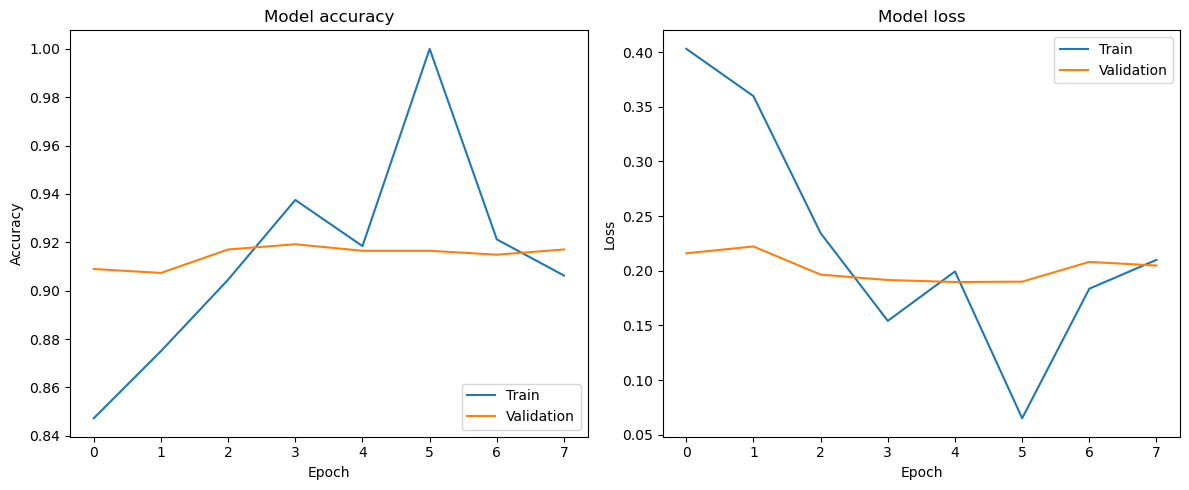


Evaluating model on test set...
59/59 ━━━━━━━━━━━━━━━━━━━━ 25s 416ms/step

Prediction time for 1863 images: 25.27 seconds
Average prediction time per image: 13.56 ms

Classification Report:
                                  precision    recall  f1-score   support

         Corn_Corn___Common_Rust       0.99      1.00      0.99       179
      Corn_Corn___Gray_Leaf_Spot       0.73      0.79      0.76        77
             Corn_Corn___Healthy       0.98      0.99      0.99       174
Corn_Corn___Northern_Leaf_Blight       0.88      0.84      0.86       148
    Potato_Potato___Early_Blight       1.00      0.97      0.98       150
         Potato_Potato___Healthy       0.87      0.87      0.87        23
     Potato_Potato___Late_Blight       0.95      0.98      0.96       150
             Rice_Rice___Healthy       0.86      0.70      0.77       223
          Rice_Rice___Leaf_Blast       0.65      0.83      0.73       147
          Rice_Rice___Neck_Blast       1.00      1.00      1.00     

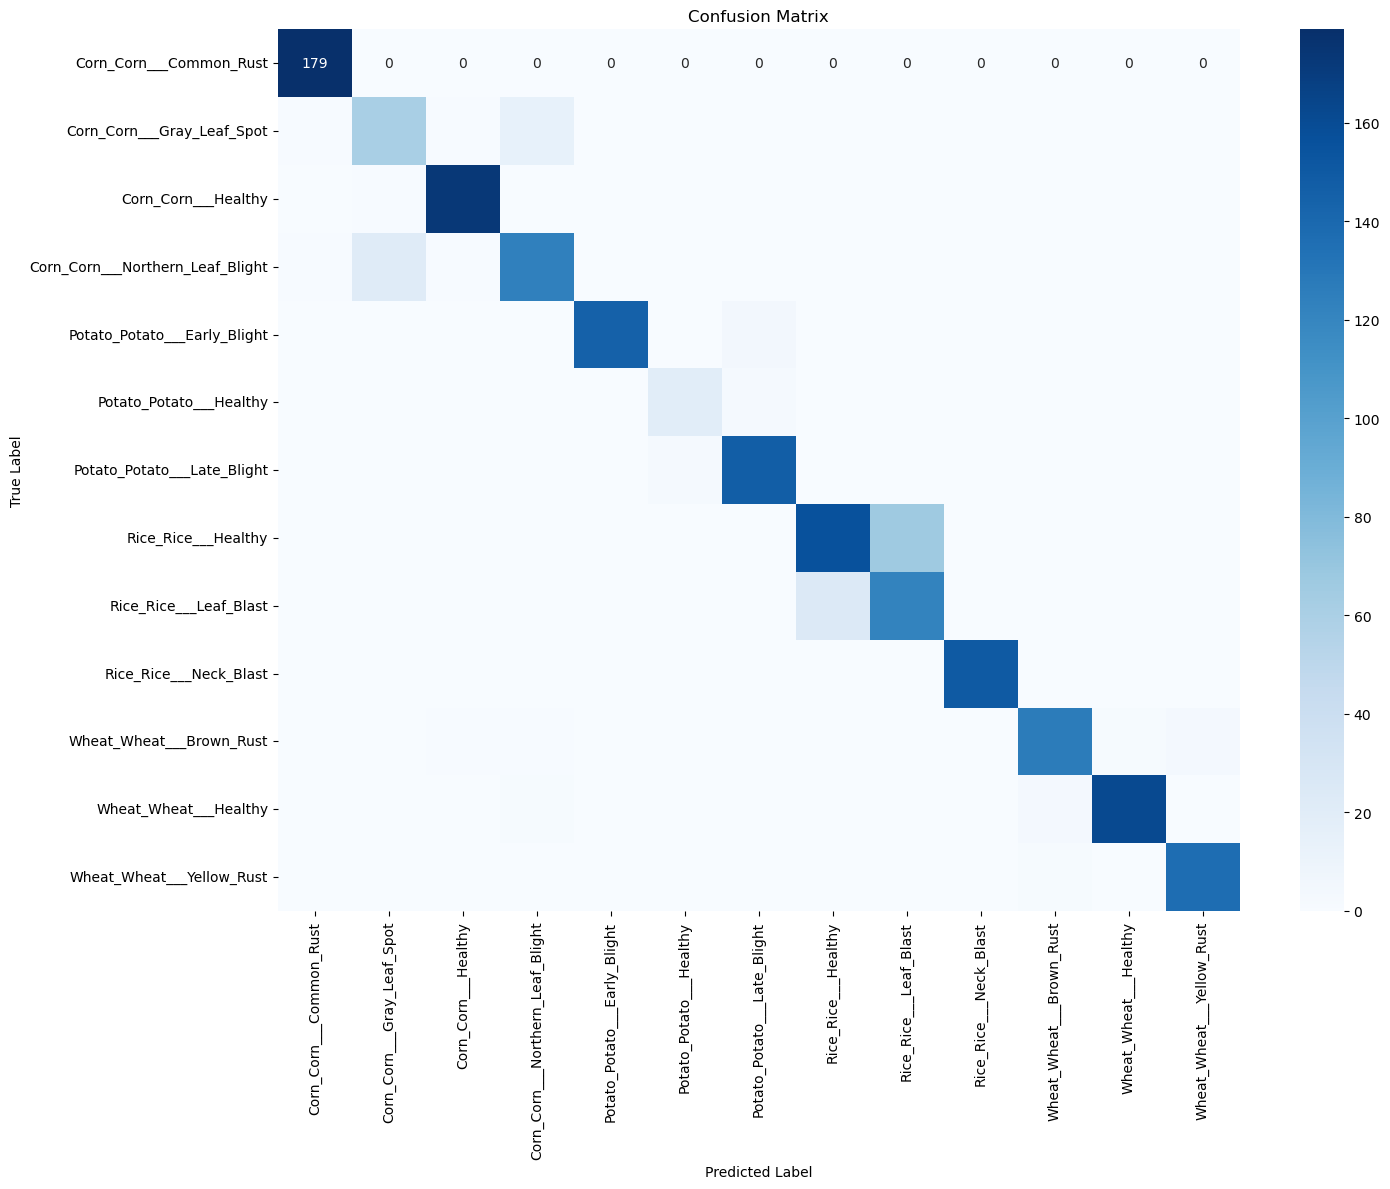


Example Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


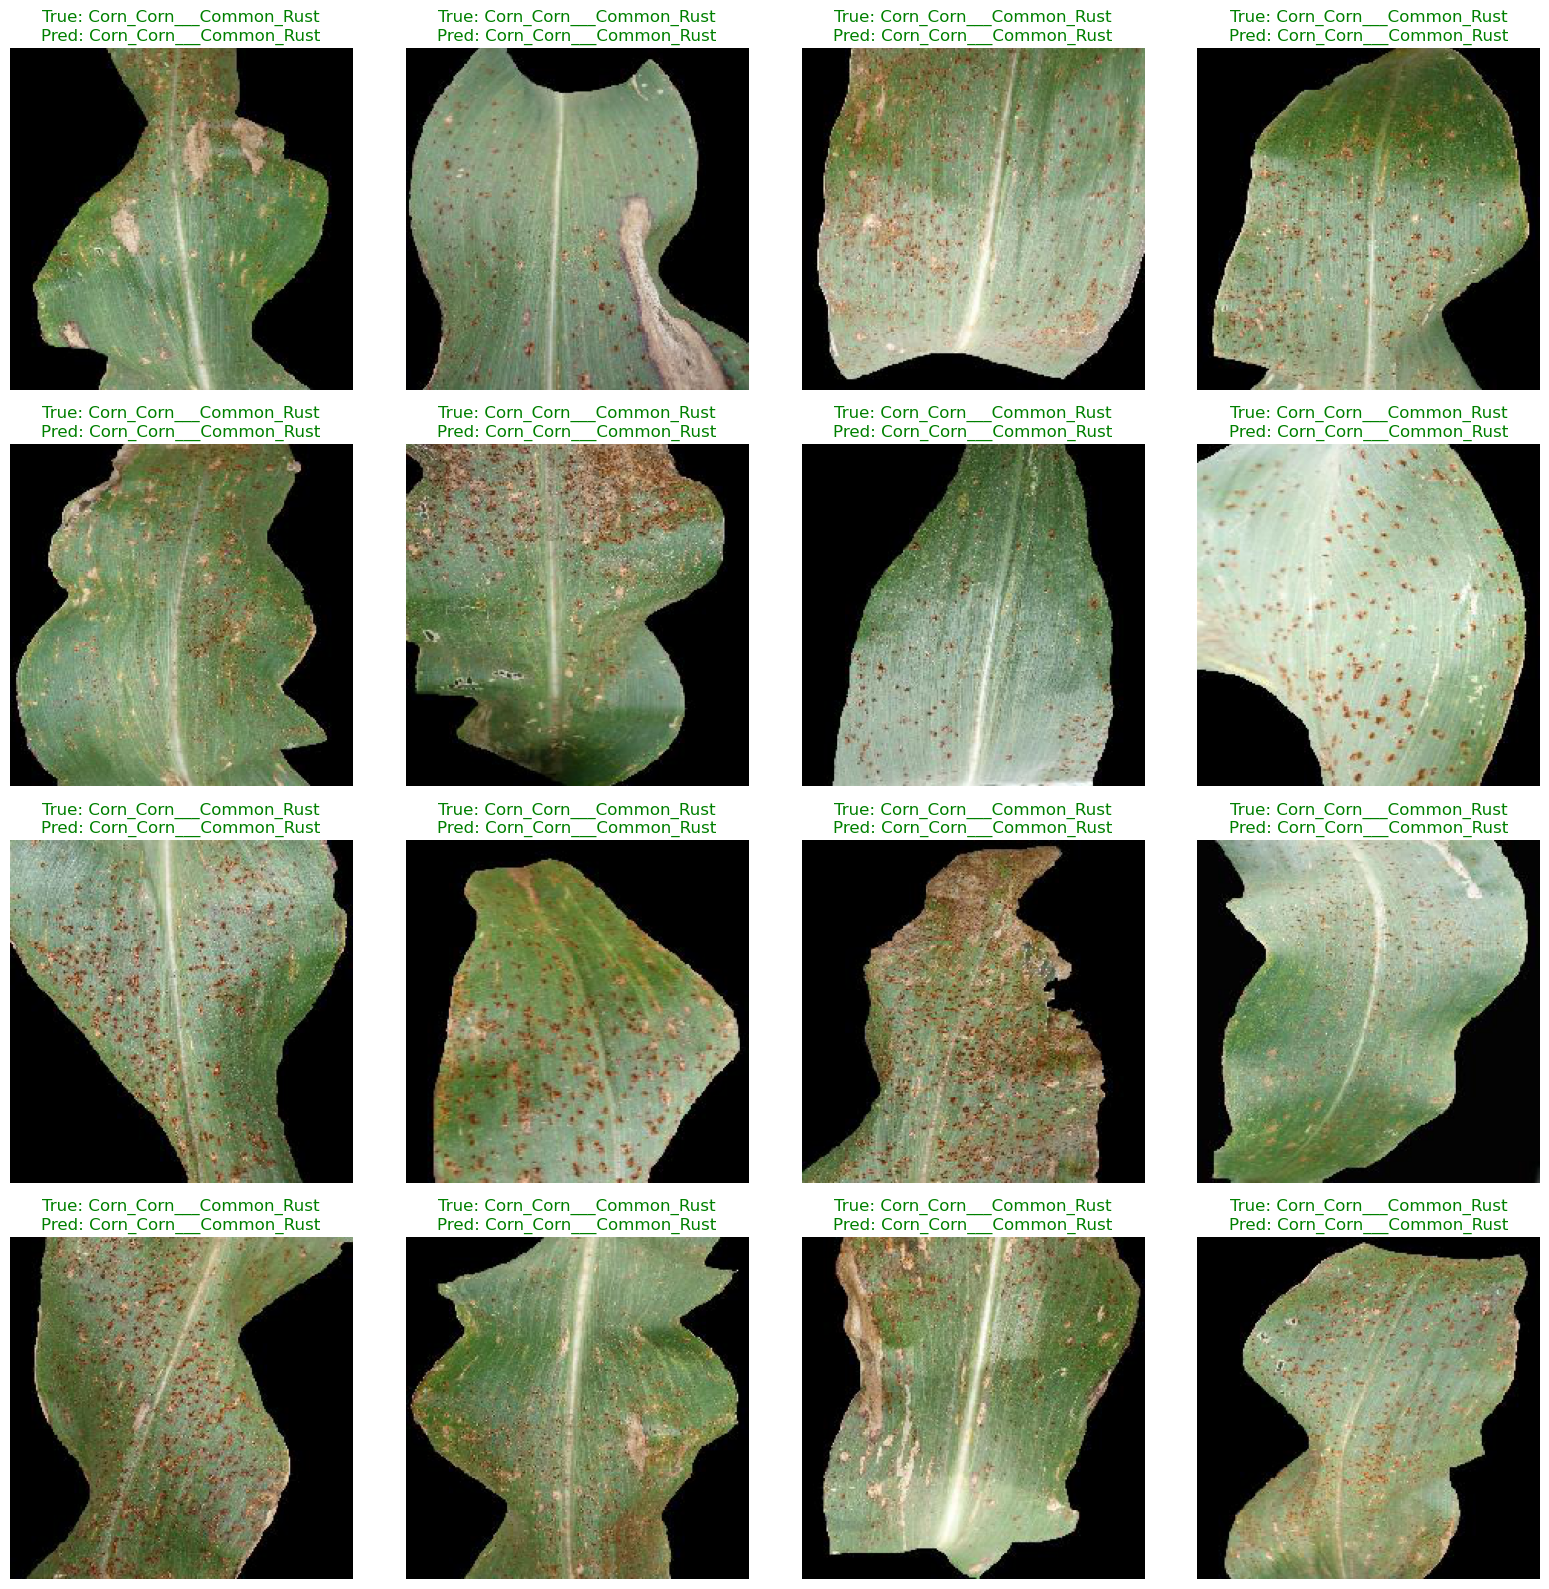

Model saved as 'mobilenet_crop_disease_model.h5'


In [44]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Hyperparameters - optimized for faster training
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10  # Reduced from 30 to train faster
LEARNING_RATE = 0.001

def build_mobilenet_model(num_classes):
    """
    Build a MobileNetV2-based model for crop disease classification
    MobileNetV2 is much lighter and faster than EfficientNetB7
    """
    # Load MobileNetV2 pre-trained on ImageNet without the top layer
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the base model for transfer learning
    base_model.trainable = False

    # Add custom classification head (simpler than the original)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_callbacks():
    """
    Create callbacks for model training
    """
    # Checkpoint to save the best model
    checkpoint = ModelCheckpoint(
        "mobilenet_crop_disease_best.h5",
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,  # Reduced patience for faster training
        restore_best_weights=True,
        verbose=1
    )

    return [checkpoint, early_stopping]

def plot_training_history(history):
    """
    Plot training & validation accuracy and loss values
    """
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix for model evaluation
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def evaluate_model(model, test_generator):
    """
    Evaluate the model on the test set
    """
    # Get class indices
    class_indices = test_generator.class_indices
    class_names = list(class_indices.keys())

    # Get true labels
    y_true = test_generator.classes

    # Predict on test data
    start_time = time.time()
    y_pred_probs = model.predict(test_generator, verbose=1)
    prediction_time = time.time() - start_time

    y_pred = np.argmax(y_pred_probs, axis=1)

    # Print evaluation metrics
    print(f"\nPrediction time for {test_generator.samples} images: {prediction_time:.2f} seconds")
    print(f"Average prediction time per image: {prediction_time/test_generator.samples*1000:.2f} ms")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calculate accuracy
    accuracy = (y_pred == y_true).mean()
    print(f"Test Accuracy: {accuracy:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names)

    # Display some example predictions
    print("\nExample Predictions:")
    batch_x, batch_y = next(iter(test_generator))
    batch_preds = model.predict(batch_x)
    batch_pred_classes = np.argmax(batch_preds, axis=1)
    batch_true_classes = np.argmax(batch_y, axis=1)

    plt.figure(figsize=(16, 16))
    for i in range(min(16, len(batch_x))):
        plt.subplot(4, 4, i+1)
        plt.imshow(batch_x[i])
        true_class = class_names[batch_true_classes[i]]
        pred_class = class_names[batch_pred_classes[i]]
        color = "green" if true_class == pred_class else "red"
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('example_predictions.png')
    plt.show()

    return accuracy, y_pred, y_true

def train_model(train_generator, validation_generator, test_generator=None):
    """
    Train and evaluate the model
    """
    # Get number of classes from the generator
    num_classes = len(train_generator.class_indices)
    print(f"Building model for {num_classes} classes.")

    # Create the model
    model = build_mobilenet_model(num_classes)

    # Print model summary
    # model.summary()

    # Create callbacks
    callbacks = create_callbacks()

    # Start timer
    start_time = time.time()

    # Train the model
    print("\nTraining the model...")
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    # Calculate training time
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set if provided
    if test_generator:
        print("\nEvaluating model on test set...")
        accuracy, y_pred, y_true = evaluate_model(model, test_generator)

    # Save the final model
    model.save('mobilenet_crop_disease_model.h5')
    print("Model saved as 'mobilenet_crop_disease_model.h5'")

    return model, history

# Run the training using your existing generators
if __name__ == "__main__":
    # Check if the generators exist in the global namespace
    if 'train_generator' in globals() and 'validation_generator' in globals() and 'test_generator' in globals():
        print("Found existing data generators, starting model training...")

        # Display some info about the datasets
        print(f"Training set: {train_generator.samples} images")
        print(f"Validation set: {validation_generator.samples} images")
        print(f"Test set: {test_generator.samples} images")
        print(f"Number of classes: {len(train_generator.class_indices)}")

        # Train the model
        model, history = train_model(
            train_generator,
            validation_generator,
            test_generator
        )
    else:
        print("Data generators not found. Please run the data preprocessing code first.")

In [29]:
print(tf.test.is_gpu_available(cuda_only=True, min_cuda_compute_capability=None))
print(tf.config.list_physical_devices('GPU'))


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False
[]


In [30]:
pip install tensorflow-gpu==2.14.0


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.14.0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.14.0


In [ ]:
import os
import warnings
import tensorflow as tf

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Only show errors
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

